In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load main dataset and cluster labels, then merge to create a dataframe with cluster assignments
import pandas as pd

merged_main = pd.read_csv('../data/processed_data/interaction_mode_results/main_clustering/clustered_data.csv')

merged_main

,WALLET,TX_PER_MONTH,TOKEN_DIVERSITY,PROTOCOL_DIVERSITY,TOTAL_TRANSFER_USD,INTERACTION_DIVERSITY,ACTIVE_DURATION_DAYS,AVG_TRANSFER_USD,USD_TRANSFER_STDDEV,DEX_EVENTS,...,CHADMIN_EVENTS,DEFI_EVENTS,BRIDGE_EVENTS,NFT_EVENTS,TOKEN_EVENTS,FLOTSAM_EVENTS,BRIDGE_OUTFLOW_COUNT,BRIDGE_INFLOW_COUNT,BRIDGE_TOTAL_VOLUME_USD,cluster_label
0,0xecb113be97a619aa4d070491505847000f964448,8.166667,6,9,2840.47,5,177,41.166232,88.745481,5,...,0,0,1,0,28,0,1,0,499.88,7
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,8.666667,2,8,3733.59,10,172,56.569545,185.180716,1,...,0,0,0,0,0,0,0,0,0.00,-1
2,0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9,13.000000,5,26,3771.93,14,169,62.865500,135.890912,0,...,0,0,6,0,23,0,0,0,0.00,12
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,6.833333,1,2,12977.28,2,170,370.779429,318.130714,0,...,0,0,0,0,35,0,0,0,0.00,3
4,0xa967e15e71455940dfab4c08719abae50401babd,7.500000,5,6,18935.76,6,156,236.697000,478.737614,5,...,0,0,10,0,25,0,9,0,1206.05,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20169,0x4379b4e1602aa5b548247c6792bfd0bc795c47d3,1.833333,5,2,1813.62,2,21,9.750645,22.610886,0,...,0,0,0,0,0,0,0,0,0.00,3
20170,0x82e4820320656aedd7d90d6aa435a180bc7b635c,1.000000,5,4,491.79,2,22,8.196500,18.482865,0,...,0,0,0,0,0,0,0,0,0.00,3
20171,0x7de482f497b52e32832b6d9f9c43673d3af503b7,3.166667,1,2,0.48,3,157,0.096000,0.084994,0,...,0,0,0,0,0,0,0,0,0.00,3
20172,0xc410c6b0e36bcad53d7d6b09c20d77c0aca8e6a1,1.000000,1,4,9.62,4,124,9.620000,0.000000,0,...,0,0,0,0,0,0,0,0,0.00,3


In [3]:
feature_analysis_results = {}
for cluster in sorted(merged_main['cluster_label'].dropna().unique()):
    cluster_df = merged_main[merged_main['cluster_label'] == cluster]
    # Use the feature analysis function from interaction_mode_features_v2.py
    # Replace 'your_feature_analysis_function' with the actual function name
    # Example: result = interaction_mode_features_v2.analyze_features(cluster_df)
    # For demonstration, we'll just compute means for all numeric columns
    result = cluster_df.describe().T[['mean', 'std', 'min', 'max']]
    feature_analysis_results[cluster] = result
# Combine all results into a single DataFrame for easy comparison
combined_feature_analysis = pd.concat(feature_analysis_results, names=['cluster_label'])
combined_feature_analysis

mean           std    min  \
cluster_label                                                               
-1            TX_PER_MONTH                 19.100927  4.957916e+01   1.00   
              TOKEN_DIVERSITY               4.242555  2.560051e+00   1.00   
              PROTOCOL_DIVERSITY           10.772005  1.441968e+01   1.00   
              TOTAL_TRANSFER_USD       101970.263210  3.222417e+06   0.03   
              INTERACTION_DIVERSITY         9.119457  4.015523e+00   1.00   
...                                              ...           ...    ...   
 20           FLOTSAM_EVENTS                0.000000  0.000000e+00   0.00   
              BRIDGE_OUTFLOW_COUNT        101.991905  2.125126e+03   0.00   
              BRIDGE_INFLOW_COUNT           0.000000  0.000000e+00   0.00   
              BRIDGE_TOTAL_VOLUME_USD  120443.300143  1.994746e+06   0.00   
              cluster_label                20.000000  0.000000e+00  20.00   

                                                max  
cluster_label                                        
-1            TX_PER_MONTH             2.221000e+03  
              TOKEN_DIVERSITY          3.300000e+01  
              PROTOCOL_DIVERSITY       6.750000e+02  
              TOTAL_TRANSFER_USD       1.671072e+08  
              INTERACTION_DIVERSITY    3.900000e+01  
...                                             ...  
 20           FLOTSAM_EVENTS           0.000000e+00  
              BRIDGE_OUTFLOW_COUNT     7.523600e+04  
              BRIDGE_INFLOW_COUNT      0.000000e+00  
              BRIDGE_TOTAL_VOLUME_USD  6.795146e+07  
              cluster_label            2.000000e+01  

[484 rows x 4 columns]

DATAFRAME TO FIND KEY VALUES FOR FEATURES IN EACH CLUSTER IS ABOVE

The below is now focused on looking at the other features' values for the clusters selected in the output of interaction_mode_cluster_selection_v2.py - this includes 7, 4, 5 and 12 for DEX_EVENTS, CEX_EVENTS, DEFI_EVENTS and BRIDGE_EVENTS respectively.

When looking at the values being produced for analysis of each cluster being looked into - it is important to remember the following:

- Median is calculated as the median of all non-null values in the cluster
- Activity level is simply the proportion of non-null values in the cluster for the given feature - the minimum threshold for selection with the method used is 10%.
- Density used to calculate the score on which these notebooks are ranked to be selected is still just 1 as a proxy - doesn't use the probabilities from clustering results as initially intended just yet **.

In [4]:
# For every cluster in the main dataset, compute Activity Level, Median Value, Score, Mean, Std, Min, and Max for each feature of interest
features_of_interest = ['DEX_EVENTS', 'CEX_EVENTS', 'DEFI_EVENTS', 'BRIDGE_EVENTS']
min_activity_threshold = 0.1  # 10% minimum activity, as in v2
results = []
for cluster_label in sorted(merged_main['cluster_label'].unique()):
    cluster_df = merged_main[merged_main['cluster_label'] == cluster_label]
    cluster_size = len(cluster_df)
    for feature in features_of_interest:
        if feature in cluster_df.columns:
            non_zero_count = (cluster_df[feature] != 0).sum()
            total_count = cluster_df[feature].notnull().sum()
            non_zero_proportion = non_zero_count / total_count if total_count > 0 else float('nan')
            median_value = cluster_df[feature].dropna().median()
            mean_value = cluster_df[feature].mean()
            std_value = cluster_df[feature].std()
            min_value = cluster_df[feature].min()
            max_value = cluster_df[feature].max()
            if non_zero_proportion < min_activity_threshold:
                score = 0.0
            else:
                variance = cluster_df[feature].var()
                density = 1  # proxy value
                intensity = np.log(1 + mean_value) * (1 + non_zero_proportion) if mean_value > 0 else 0.001
                if variance is None or np.isnan(variance) or variance < 1e-10:
                    variance = 1e-6
                base_score = (cluster_size * density * intensity) / variance
                activity_bonus = 1 + (non_zero_proportion - min_activity_threshold) * 2
                score = base_score * activity_bonus
            results.append({
                'cluster_label': cluster_label,
                'feature': feature,
                'activity_level': non_zero_proportion,
                'median_value': median_value,
                'mean': mean_value,
                'std': std_value,
                'min': min_value,
                'max': max_value,
                'score': score,
                'cluster_size': cluster_size
            })
        else:
            results.append({
                'cluster_label': cluster_label,
                'feature': feature,
                'activity_level': None,
                'median_value': None,
                'mean': None,
                'std': None,
                'min': None,
                'max': None,
                'score': None,
                'cluster_size': cluster_size
            })
results_df = pd.DataFrame(results)
display(results_df)

,cluster_label,feature,activity_level,median_value,mean,std,min,max,score,cluster_size
0,-1,DEX_EVENTS,0.699537,2.0,9.575778,21.503532,0,271,57.609383,3022
1,-1,CEX_EVENTS,0.055923,0.0,0.084050,0.448120,0,7,0.000000,3022
2,-1,DEFI_EVENTS,0.831899,2.0,2.891463,2.591229,0,21,2760.200666,3022
3,-1,BRIDGE_EVENTS,0.216413,0.0,1.951026,12.950786,0,112,29.239748,3022
4,0,DEX_EVENTS,0.000000,0.0,0.000000,0.000000,0,0,0.000000,797
...,...,...,...,...,...,...,...,...,...,...
83,19,BRIDGE_EVENTS,0.785847,5.0,21.510242,151.467610,0,3418,0.308711,537
84,20,DEX_EVENTS,0.756667,6.0,83.517143,1368.652787,0,35806,0.020214,2100
85,20,CEX_EVENTS,0.001429,0.0,0.001429,0.037778,0,1,0.000000,2100
86,20,DEFI_EVENTS,0.888571,5.0,35.900476,848.166908,0,38838,0.051265,2100


In [5]:
print('Cluster 7 - DEX_EVENTS')
print()
print(results_df[results_df['cluster_label'] == 7])

Cluster 7 - DEX_EVENTS

    cluster_label        feature  activity_level  median_value      mean  \
32              7     DEX_EVENTS        0.663239           1.0  1.933162   
33              7     CEX_EVENTS        0.339332           0.0  1.316195   
34              7    DEFI_EVENTS        0.015424           0.0  0.015424   
35              7  BRIDGE_EVENTS        0.660668           1.0  2.041131   

         std  min  max       score  cluster_size  
32  2.592745    0   16  220.237185           389  
33  2.255639    0   10  127.177067           389  
34  0.123391    0    1    0.000000           389  
35  2.774768    0   14  197.962691           389  


In [6]:
print('Cluster 4 - CEX_EVENTS')
print()
print(results_df[results_df['cluster_label'] == 4])

Cluster 4 - CEX_EVENTS

    cluster_label        feature  activity_level  median_value      mean  \
20              4     DEX_EVENTS        0.012461           0.0  0.012461   
21              4     CEX_EVENTS        0.411215           0.0  0.411215   
22              4    DEFI_EVENTS        0.588785           1.0  1.280374   
23              4  BRIDGE_EVENTS        1.000000           2.0  3.669782   

         std  min  max        score  cluster_size  
20  0.111105    0    1     0.000000           321  
21  0.492822    0    1  1042.343526           321  
22  1.677765    0    8   295.356095           321  
23  3.372220    1   15   243.610308           321  


In [7]:
    # Use the feature analysis function from interaction_mode_target_features_v2.py


In [8]:
    # Example: result = interaction_mode_target_features_v2.analyze_features(cluster_df)


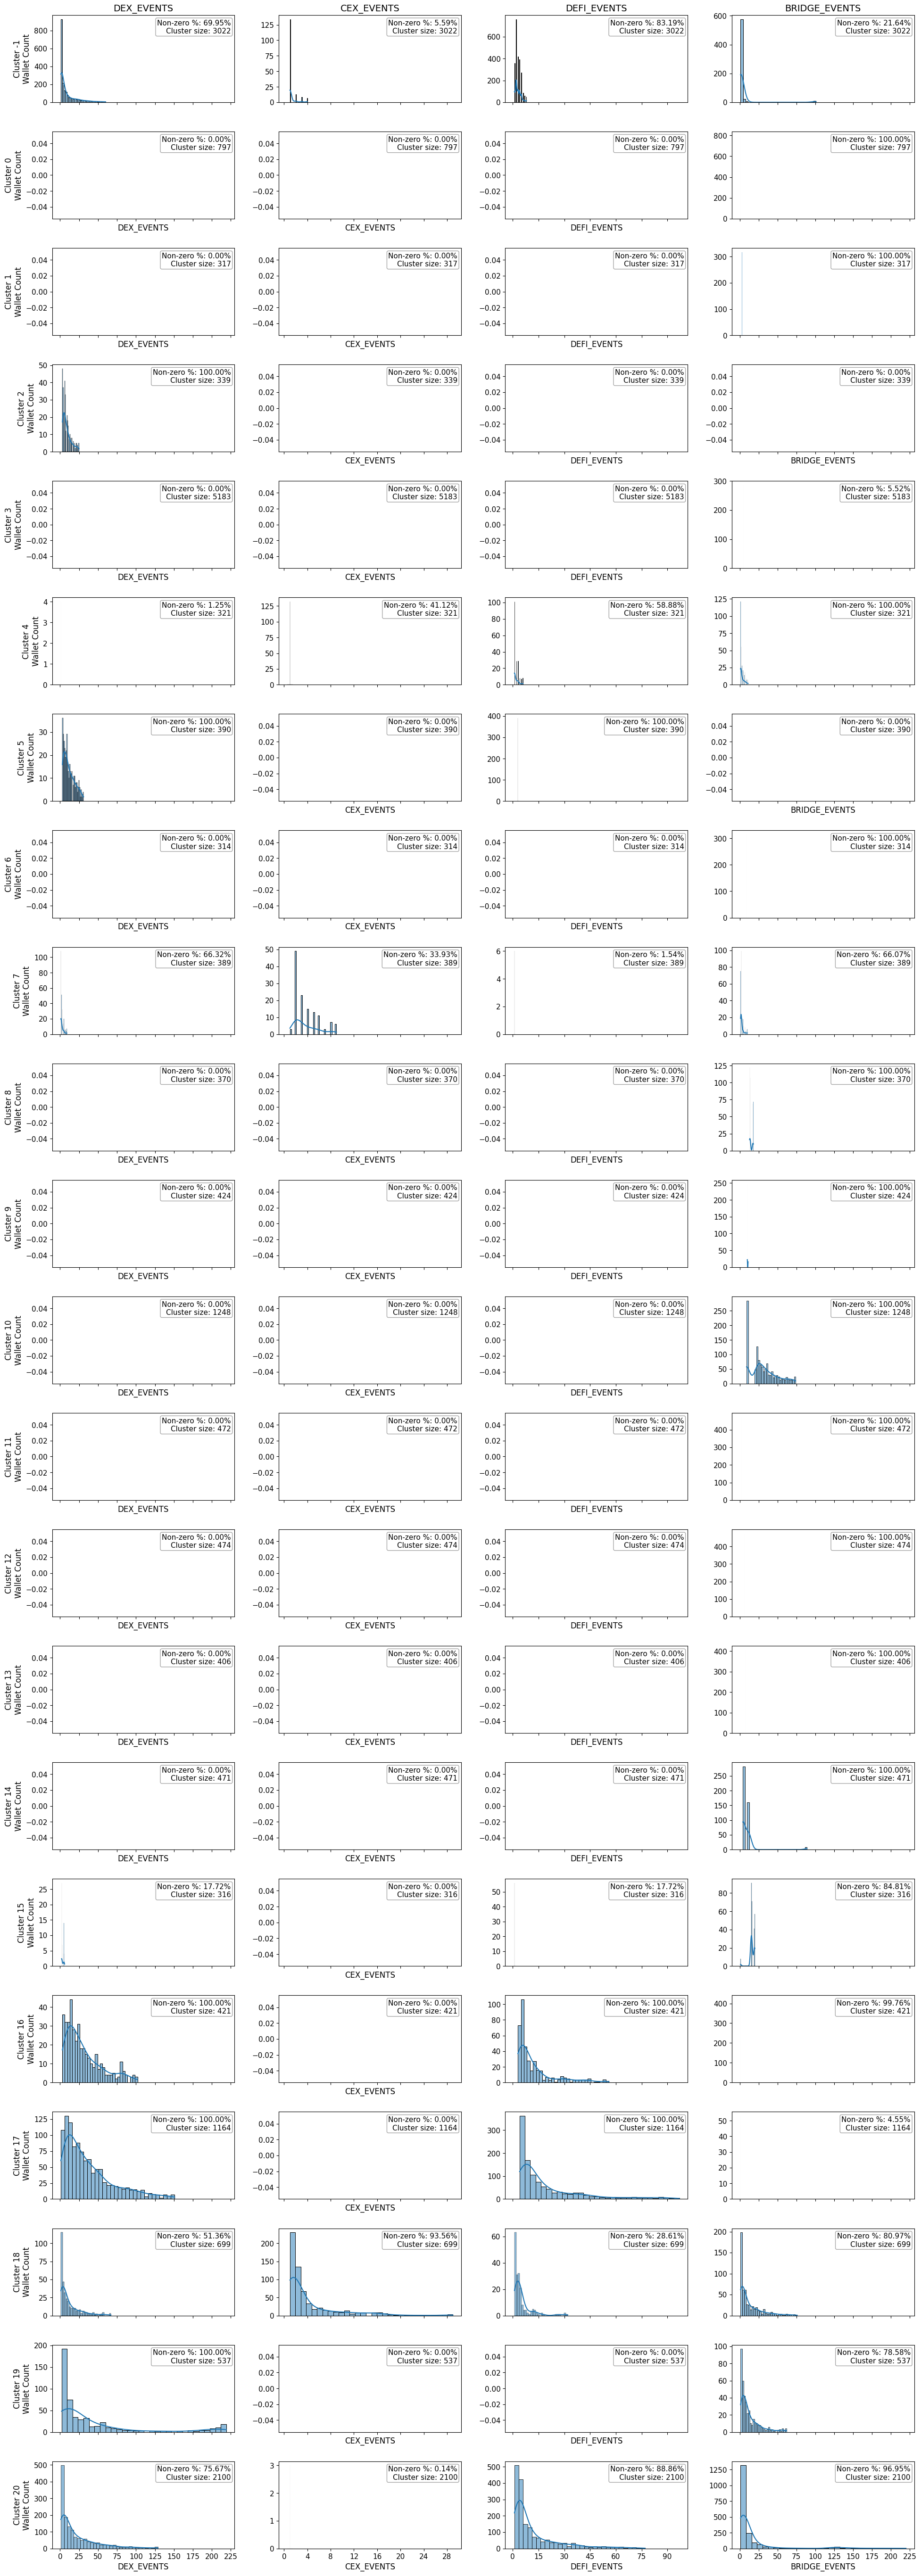

In [9]:
# Plot distribution of all four features for each cluster, using only non-zero values, and display non_zero_proportion and cluster size next to each plot
features = ['DEX_EVENTS', 'CEX_EVENTS', 'DEFI_EVENTS', 'BRIDGE_EVENTS']
clusters = sorted(merged_main['cluster_label'].dropna().unique())
num_clusters = len(clusters)
num_features = len(features)
fig_height = max(4, 2.5 * num_clusters)
fig_width = 5 * num_features
fig, axes = plt.subplots(num_clusters, num_features, figsize=(fig_width, fig_height), sharex='col')
if num_clusters == 1:
    axes = [axes]
for row_idx, cluster in enumerate(clusters):
    cluster_df = merged_main[merged_main['cluster_label'] == cluster]
    cluster_size = len(cluster_df)
    for col_idx, feature in enumerate(features):
        ax = axes[row_idx, col_idx] if num_clusters > 1 else axes[col_idx]
        feature_values = cluster_df[feature].dropna()
        non_zero_values = feature_values[feature_values != 0]
        non_zero_count = len(non_zero_values)
        total_count = len(feature_values)
        non_zero_proportion = non_zero_count / total_count if total_count > 0 else float('nan')
        if len(non_zero_values) > 0:
            p95 = non_zero_values.quantile(0.95)
            plot_values = non_zero_values[non_zero_values <= p95]
        else:
            plot_values = non_zero_values
        sns.histplot(plot_values, bins=30, kde=True, ax=ax)
        # Set consistent x-axis label and formatting
        ax.set_xlabel(feature, fontsize=12)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=False, prune=None))
        ax.ticklabel_format(style='plain', axis='x')
        ax.tick_params(axis='both', which='major', labelsize=11)
        # Set title for each column
        if row_idx == 0:
            ax.set_title(f'{feature}', fontsize=14)
        # Set y-axis label for each row
        if col_idx == 0:
            ax.set_ylabel(f'Cluster {cluster}\nWallet Count', fontsize=12)
        else:
            ax.set_ylabel('')
        # Annotate non_zero_proportion and cluster size next to the plot
        annotation = f'Non-zero %: {non_zero_proportion:.2%}\nCluster size: {cluster_size}'
        ax.text(0.98, 0.95, annotation,
                transform=ax.transAxes, fontsize=11, va='top', ha='right',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', alpha=0.7))
plt.tight_layout(pad=2)
plt.show()

PRODUCING THE NECCESSARY CODE TO EFFECTIVELY ANALYSE AND LOOK INTO THE DISTANCE SCORES PRODUCED WITH THE MOST RECENT VERSION AND OUTPUT OF THE CALCULATE_DISTANCE_FROM_MEDIAN.PY FILE.

The process needed to complete this involves analysing how the results of the clustering selection and median production process (looked at above) have led themselves to allow for a distance measure production from which analytial value and recommendations can be provided for key decisions. 
This allows for the best possible evaluations in terms of viability for producing the output being - can a CEX use this as a part of their wallet segmentation in terms of guiding key decision making to achieve the business initiative through this use case. **CLEAR NEED HERE TO KEEP THE TLADS PROCESS IN MIND WHEN LOOKING AT THESE DISTANCE SCORES**

Another key thing to remember - in some cases (only looking at the main dataset initially here), the median value for two features being looked at are produced from the same cluster. This leads to new ways of thinking and new interpretations about the likely correlations of these features which as a result leads to impacts on wallet level data etc. Need to keep in thoughts when thinking about these recommendations and framing to a CEX.

# Analysis of Interaction Mode Distance Scores
In this section, we analyse the distance scores produced by the most recent version of `calculate_distance_from_median.py`, using the file `normalized_distances.csv`. We will:

- Explore the distribution of distance scores for each interaction mode feature (DEX, CEX, DEFI, BRIDGE).

- Relate these distance scores to the average and median feature values in the main clustering results.
- Investigate how distance from the median relates to cluster assignments and feature activity.
- Provide visualisations to support interpretation and recommendations.

In [10]:
# Load full normalized distance scores (with all feature values, medians, cluster labels, and normalized distances)
distance_df = pd.read_csv('../data/processed_data/interaction_mode_results/main_clustering/full_normalized_distances.csv')
# Columns: WALLET, cluster_label, <features...>, <feature>_median, <feature>_normalized_distance
features = ['DEX_EVENTS', 'CEX_EVENTS', 'DEFI_EVENTS', 'BRIDGE_EVENTS']
distance_cols = [f'{f}_normalized_distance' for f in features]
distance_df.head()

,WALLET,TX_PER_MONTH,TOKEN_DIVERSITY,PROTOCOL_DIVERSITY,TOTAL_TRANSFER_USD,INTERACTION_DIVERSITY,ACTIVE_DURATION_DAYS,AVG_TRANSFER_USD,USD_TRANSFER_STDDEV,DEX_EVENTS,...,BRIDGE_TOTAL_VOLUME_USD,cluster_label,DEX_EVENTS_MEDIAN,CEX_EVENTS_MEDIAN,BRIDGE_EVENTS_MEDIAN,DEFI_EVENTS_MEDIAN,DEX_EVENTS_NORM_DIST,CEX_EVENTS_NORM_DIST,BRIDGE_EVENTS_NORM_DIST,DEFI_EVENTS_NORM_DIST
0,0xecb113be97a619aa4d070491505847000f964448,8.166667,6,9,2840.47,5,177,41.166232,88.745481,5,...,499.88,7,29.0,2.0,29.0,12.0,0.473197,1.0,1.000000,1.0
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,8.666667,2,8,3733.59,10,172,56.569545,185.180716,1,...,0.00,-1,29.0,2.0,29.0,12.0,0.796205,1.0,1.255958,1.0
2,0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9,13.000000,5,26,3771.93,14,169,62.865500,135.890912,0,...,0.00,12,29.0,2.0,29.0,12.0,1.000000,1.0,0.537393,1.0
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,6.833333,1,2,12977.28,2,170,370.779429,318.130714,0,...,0.00,3,29.0,2.0,29.0,12.0,1.000000,1.0,1.255958,1.0
4,0xa967e15e71455940dfab4c08719abae50401babd,7.500000,5,6,18935.76,6,156,236.697000,478.737614,5,...,1206.05,19,29.0,2.0,29.0,12.0,0.473197,1.0,0.370489,1.0


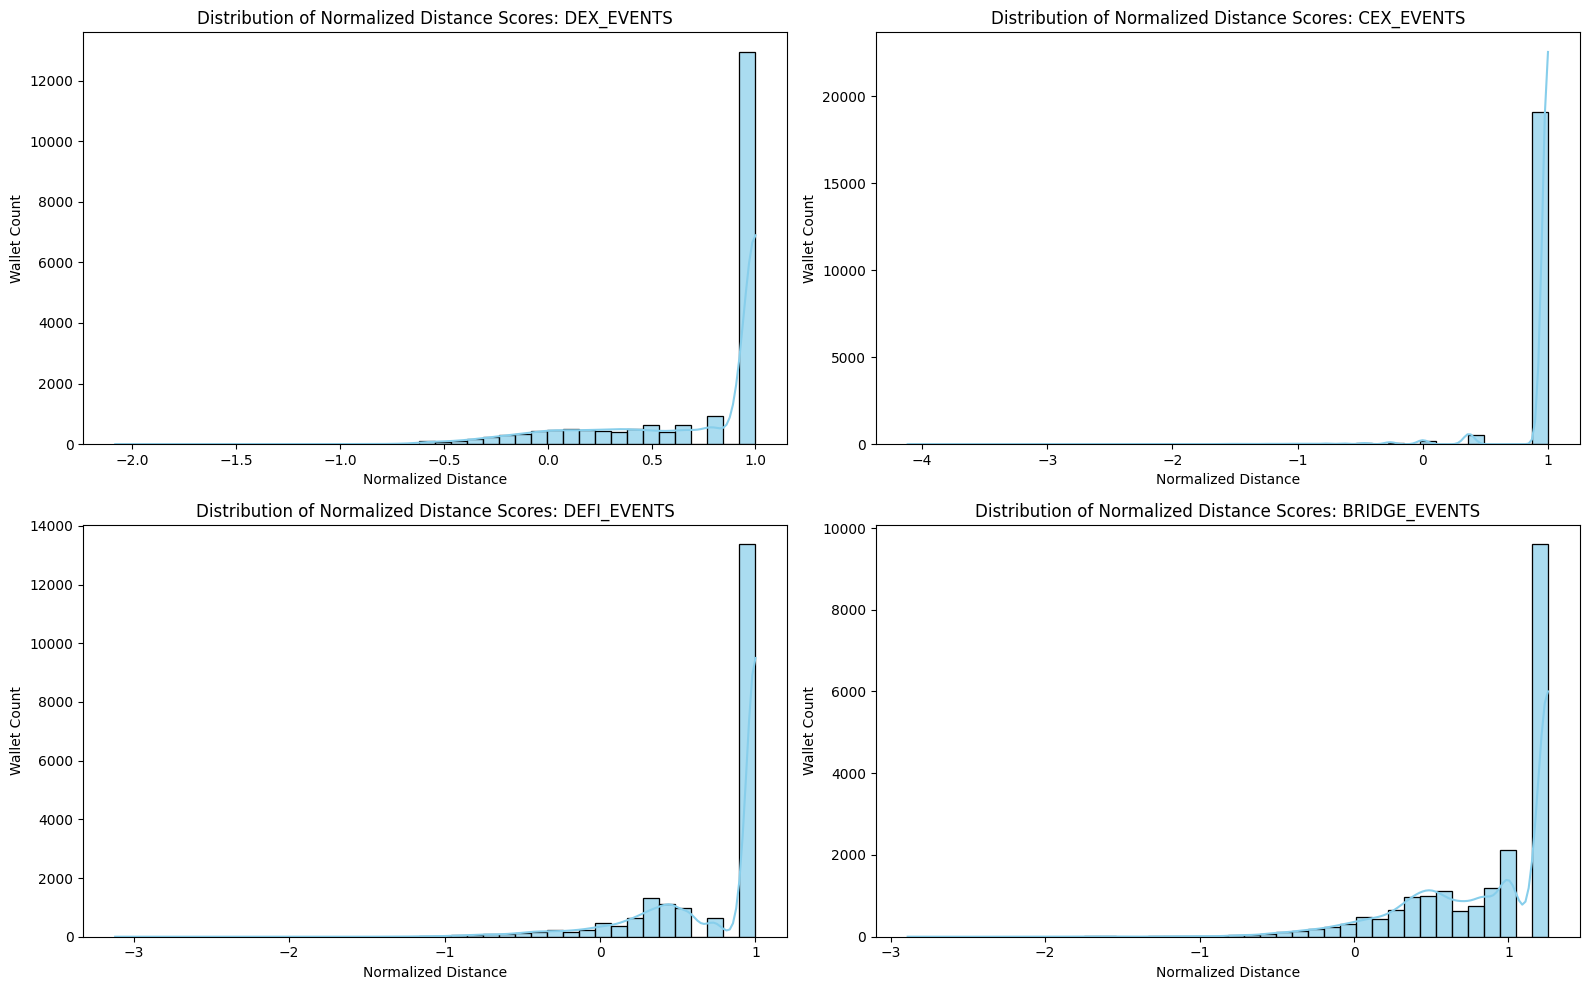

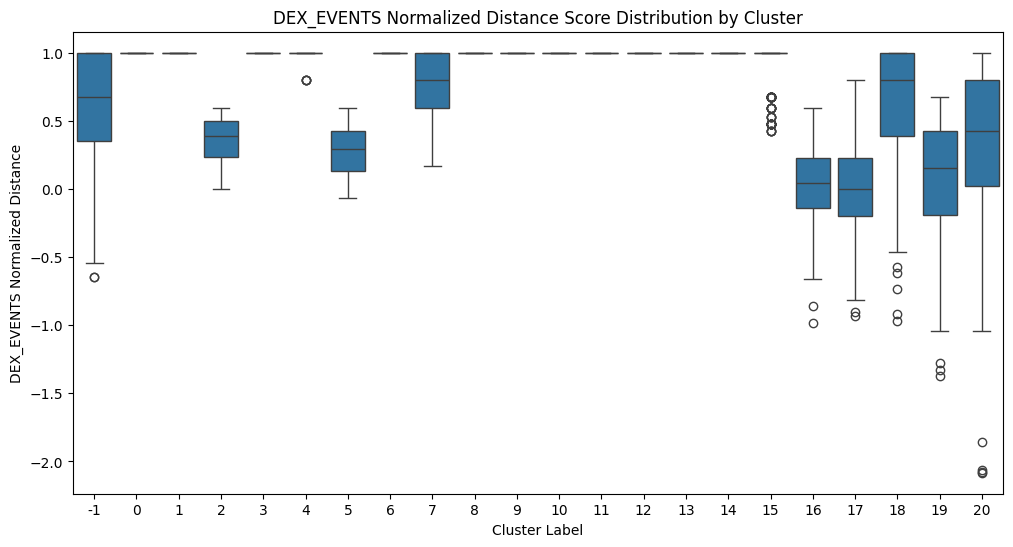

In [11]:
# Plot distribution of normalized distance scores for each feature overall and by cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
for i, feature in enumerate(features):
    ax = axes[i]
    dist_col = f'{feature}_NORM_DIST'
    sns.histplot(distance_df[dist_col], bins=40, kde=True, ax=ax, color='skyblue', alpha=0.7)
    ax.set_title(f'Distribution of Normalized Distance Scores: {feature}')
    ax.set_xlabel('Normalized Distance')
    ax.set_ylabel('Wallet Count')
plt.tight_layout()
plt.show()

# By cluster (example for DEX_EVENTS, repeat for others as needed)
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_label', y='DEX_EVENTS_NORM_DIST', data=distance_df)
plt.title('DEX_EVENTS Normalized Distance Score Distribution by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('DEX_EVENTS Normalized Distance')
plt.show()

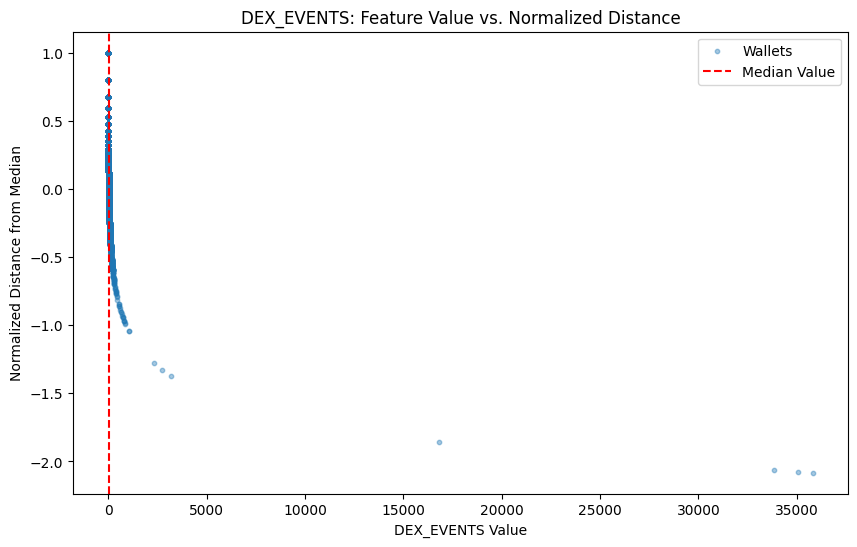

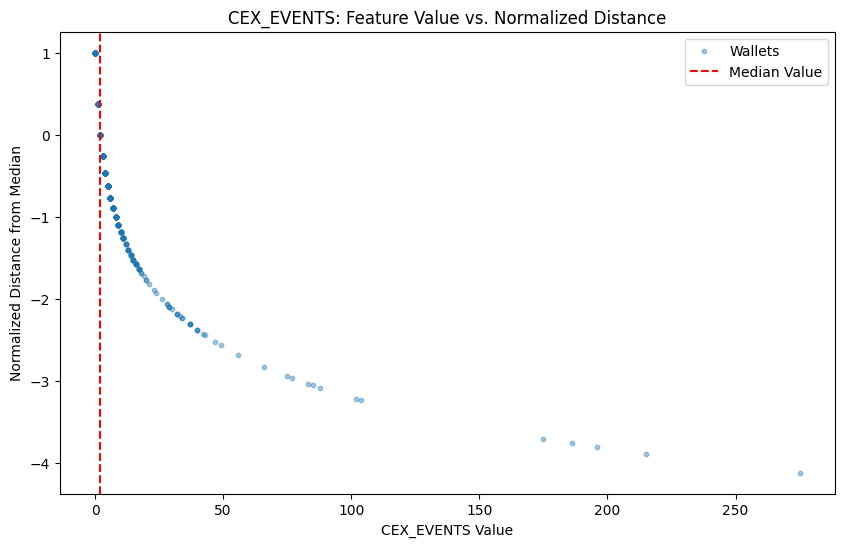

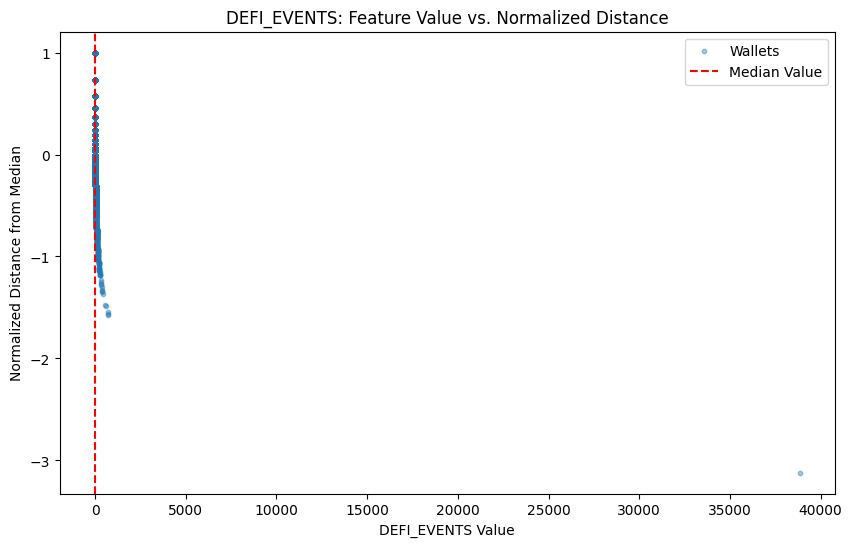

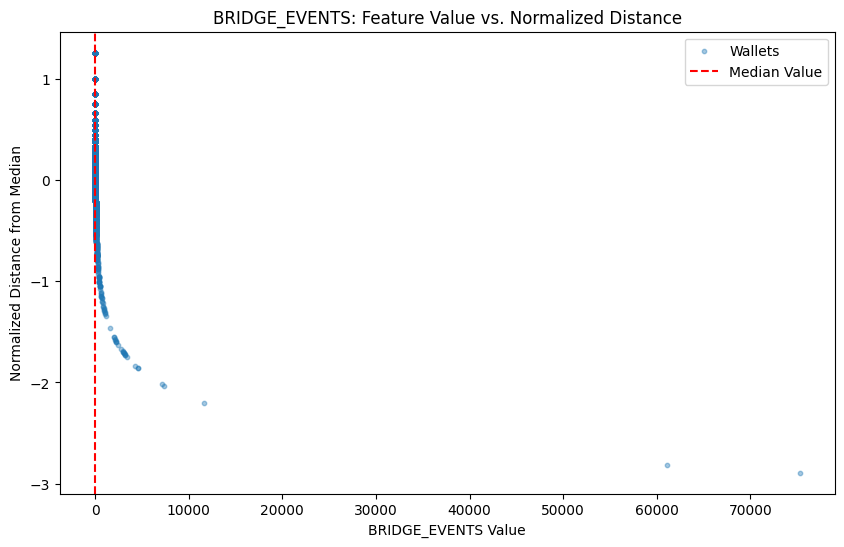

In [12]:
# Relate normalized distance scores to feature values and medians, visualise relationship
for feature in features:
    plt.figure(figsize=(10, 6))
    plt.scatter(distance_df[feature], distance_df[f'{feature}_NORM_DIST'], alpha=0.4, s=10, label='Wallets')
    median_val = distance_df[f'{feature}_MEDIAN'].iloc[0] if f'{feature}_MEDIAN' in distance_df.columns else distance_df[feature].median()
    plt.axvline(median_val, color='red', linestyle='--', label='Median Value')
    plt.title(f'{feature}: Feature Value vs. Normalized Distance')
    plt.xlabel(f'{feature} Value')
    plt.ylabel('Normalized Distance from Median')
    plt.legend()
    plt.show()

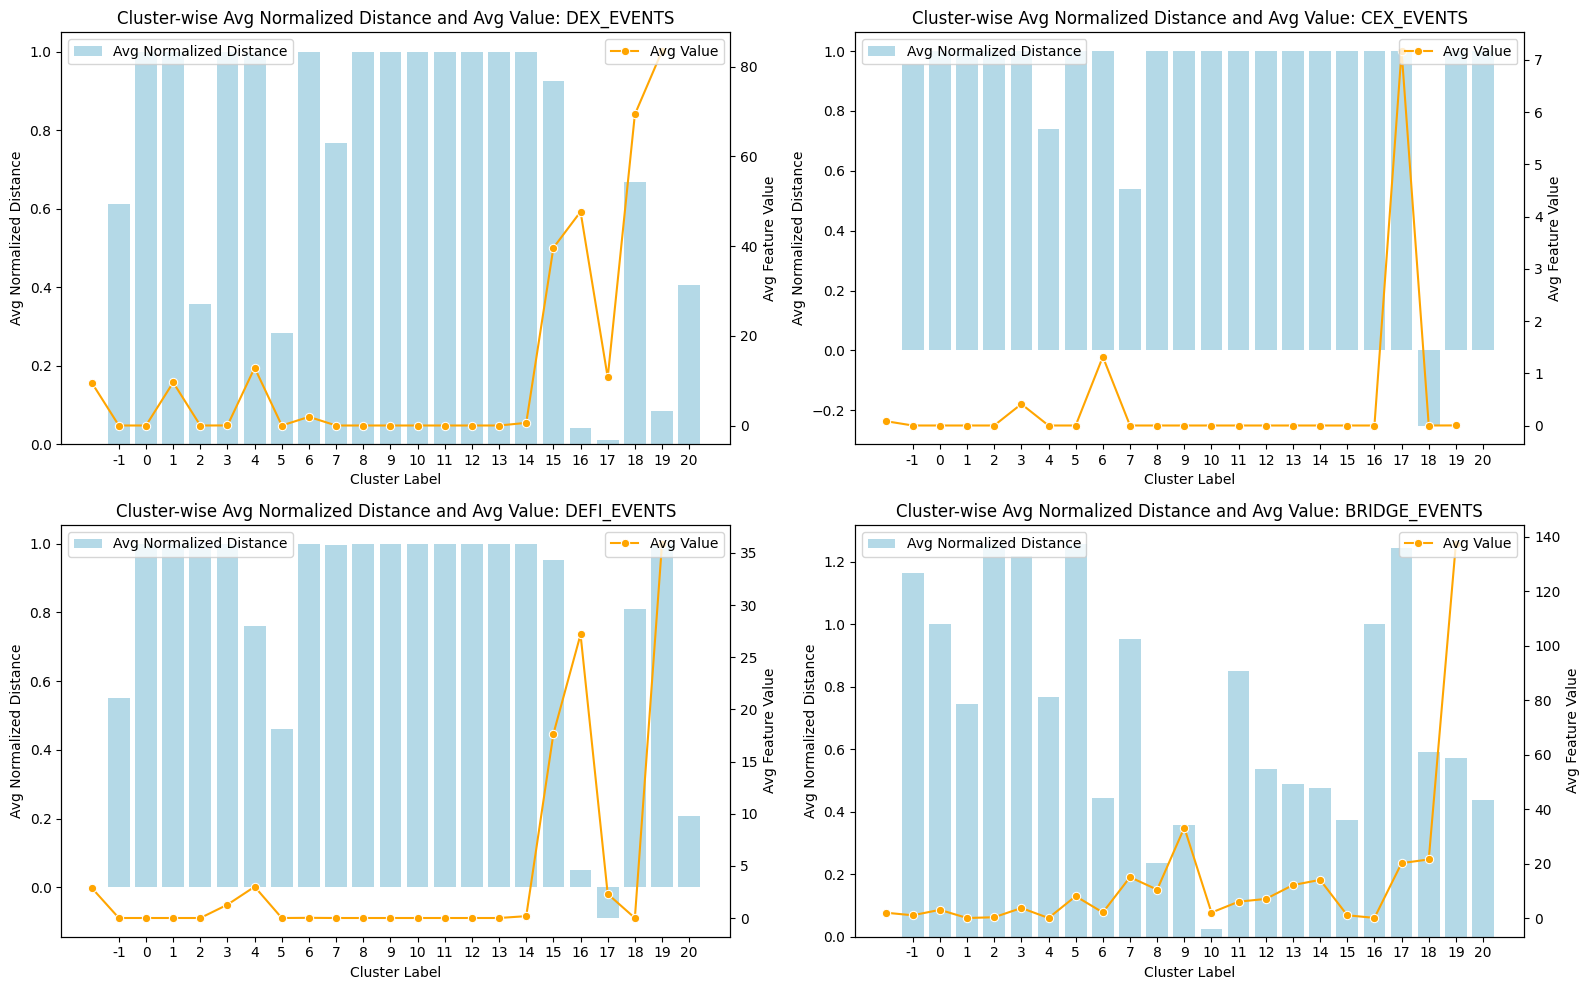

In [13]:
# Compute and visualise average normalized distance scores per cluster and feature, compare to average feature values
avg_distances = distance_df.groupby('cluster_label')[[f'{f}_NORM_DIST' for f in features]].mean().reset_index()
avg_feature_values = distance_df.groupby('cluster_label')[features].mean().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
for i, feature in enumerate(features):
    ax = axes[i]
    ax2 = ax.twinx()
    sns.barplot(x='cluster_label', y=f'{feature}_NORM_DIST', data=avg_distances, ax=ax, color='skyblue', alpha=0.7, label='Avg Normalized Distance')
    sns.lineplot(x='cluster_label', y=feature, data=avg_feature_values, ax=ax2, color='orange', marker='o', label='Avg Value')
    ax.set_title(f'Cluster-wise Avg Normalized Distance and Avg Value: {feature}')
    ax.set_xlabel('Cluster Label')
    ax.set_ylabel('Avg Normalized Distance')
    ax2.set_ylabel('Avg Feature Value')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [14]:
# Highlight wallets with highest and lowest normalized distance scores for each feature, relate to cluster and feature value
for feature in features:
    dist_col = f'{feature}_NORM_DIST'
    print(f'\nTop 5 wallets with highest {feature} normalized distance:')
    top = distance_df.nlargest(5, dist_col)
    display(top[['WALLET', 'cluster_label', feature, dist_col]])
    print(f'\nTop 5 wallets with lowest {feature} normalized distance:')
    bottom = distance_df.nsmallest(5, dist_col)
    display(bottom[['WALLET', 'cluster_label', feature, dist_col]])


Top 5 wallets with highest DEX_EVENTS normalized distance:


,WALLET,cluster_label,DEX_EVENTS,DEX_EVENTS_NORM_DIST
2,0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9,12,0,1.0
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,3,0,1.0
5,0x1198c8f481d4e63f24e3841a6961f1c71edbee14,3,0,1.0
6,0xdf2dcebdb3c9d2de6a9132708ccbd638acd89d35,15,0,1.0
7,0x7ab5985280217f28ad075e821e1abd94c4a3f6a6,6,0,1.0



Top 5 wallets with lowest DEX_EVENTS normalized distance:


,WALLET,cluster_label,DEX_EVENTS,DEX_EVENTS_NORM_DIST
5393,0x227ba91878cd157c3b5f43c5fbf452dc64f53ab5,20,35806,-2.083002
1825,0x8589ed02d6a4c2625d64c3fea62aeb58ed1db107,20,35049,-2.076720
18947,0xa81e4d5f454758d43d55c2afd0b61d45bbe16bdf,20,33816,-2.066190
4876,0xbc8a36cb3fa23afc95124e03fc5127da068394fa,20,16798,-1.860485
4771,0xb17f5972698087864fd05610c8a38f96f298d501,19,3183,-1.371486



Top 5 wallets with highest CEX_EVENTS normalized distance:


,WALLET,cluster_label,CEX_EVENTS,CEX_EVENTS_NORM_DIST
0,0xecb113be97a619aa4d070491505847000f964448,7,0,1.0
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,-1,0,1.0
2,0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9,12,0,1.0
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,3,0,1.0
4,0xa967e15e71455940dfab4c08719abae50401babd,19,0,1.0



Top 5 wallets with lowest CEX_EVENTS normalized distance:


,WALLET,cluster_label,CEX_EVENTS,CEX_EVENTS_NORM_DIST
12164,0xd727183b291c887a9ab7f1ef77f99e0e780c7f60,18,275,-4.115909
6353,0x9a168f019f0adee2b052d5efd10bdb569e76c756,18,215,-3.892789
5604,0x91dca37856240e5e1906222ec79278b16420dc92,18,196,-3.808979
7617,0x426278fe13b017d60e5d1a9ca8db7ed63cdc1cca,18,186,-3.761560
8133,0xacf7ae354e732bc189a16a04c8aa3b244b08f49a,18,175,-3.706377



Top 5 wallets with highest DEFI_EVENTS normalized distance:


,WALLET,cluster_label,DEFI_EVENTS,DEFI_EVENTS_NORM_DIST
0,0xecb113be97a619aa4d070491505847000f964448,7,0,1.0
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,-1,0,1.0
2,0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9,12,0,1.0
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,3,0,1.0
4,0xa967e15e71455940dfab4c08719abae50401babd,19,0,1.0



Top 5 wallets with lowest DEFI_EVENTS normalized distance:


,WALLET,cluster_label,DEFI_EVENTS,DEFI_EVENTS_NORM_DIST
10520,0x2aa6845f7e84b2cc1619c823bf4f6b04ec733f2c,20,38838,-3.119840
11889,0x1177e23637f4a35244fb9cf124663f3e1ecd7287,20,738,-1.575216
6278,0x322d7924bde43dc5e69c5401890cc074a26cbe27,20,709,-1.559608
13245,0xea90d635cbeaeb324e26c5f6e852cd7af049ed2c,17,689,-1.548468
6045,0x8621faf9926baae2892a0d715388d891ae79b877,20,583,-1.483441



Top 5 wallets with highest BRIDGE_EVENTS normalized distance:


,WALLET,cluster_label,BRIDGE_EVENTS,BRIDGE_EVENTS_NORM_DIST
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,-1,0,1.255958
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,3,0,1.255958
5,0x1198c8f481d4e63f24e3841a6961f1c71edbee14,3,0,1.255958
8,0xb9942c8704b43a771a35849d5cdf0dd0384142ee,-1,0,1.255958
9,0xd45cd23f26ce3b9a5220c01a8bfc70f6682246a7,7,0,1.255958



Top 5 wallets with lowest BRIDGE_EVENTS normalized distance:


,WALLET,cluster_label,BRIDGE_EVENTS,BRIDGE_EVENTS_NORM_DIST
6262,0x81af0ba454e37d0f2813c2b1ce0adc221d9d2c09,20,75240,-2.890365
2604,0xcc09c0bdb33e6bb53437860ae823b15558397576,20,61066,-2.813290
5822,0xbbe8f5fdcef4449c0a1a333b3fd0f2b3898ac8a2,20,11616,-2.200486
4882,0x1a211175a5d6dec6fe7f61ffca24afd7d1815436,20,7412,-2.034598
4642,0x614a4ff997a7681f7fc03f496bb40db34e84676b,20,7129,-2.020224


## Insights and Recommendations from Distance Score Analysis

- **Distribution of Distance Scores:** The spread and skewness of distance scores for each feature can indicate how typical or atypical most wallets are relative to the cluster medians.
- **Cluster Patterns:** Clusters with lower average distance scores for a feature may represent more 'central' or 'typical' behavior for that interaction mode.
- **Wallet Outliers:** Wallets with the highest distance scores may be outliers or represent unique behavioral patterns, potentially useful for targeted analysis or segmentation.
- **Feature Value Relationship:** Comparing feature values to their distance from the median helps identify whether high/low activity wallets are also the most 'atypical' in their cluster.
- **Business Use Case:** These analyses can guide segmentation strategies, risk assessment, or product targeting by identifying both typical and atypical wallet behaviors within each cluster.

# Analysis of Raw Distance Scores (`distances.csv`)
This section repeats all statistical evidence and visualisation functionality for the raw (un-normalized) distance scores, using `distances.csv`.

In [15]:
# Load raw distance scores and merge with main clustering data
raw_distance_df = pd.read_csv('../data/processed_data/interaction_mode_results/main_clustering/full_raw_distances.csv')
# Columns: WALLET, cluster_label, <features...>, <feature>_MEDIAN, <feature>_NORM_DIST
features = ['DEX_EVENTS', 'CEX_EVENTS', 'DEFI_EVENTS', 'BRIDGE_EVENTS']
raw_distance_cols = [f'{f}_RAW_DIST' for f in features]
raw_distance_df.head()

,WALLET,TX_PER_MONTH,TOKEN_DIVERSITY,PROTOCOL_DIVERSITY,TOTAL_TRANSFER_USD,INTERACTION_DIVERSITY,ACTIVE_DURATION_DAYS,AVG_TRANSFER_USD,USD_TRANSFER_STDDEV,DEX_EVENTS,...,BRIDGE_TOTAL_VOLUME_USD,cluster_label,DEX_EVENTS_MEDIAN,CEX_EVENTS_MEDIAN,BRIDGE_EVENTS_MEDIAN,DEFI_EVENTS_MEDIAN,DEX_EVENTS_RAW_DIST,CEX_EVENTS_RAW_DIST,BRIDGE_EVENTS_RAW_DIST,DEFI_EVENTS_RAW_DIST
0,0xecb113be97a619aa4d070491505847000f964448,8.166667,6,9,2840.47,5,177,41.166232,88.745481,5,...,499.88,7,29.0,2.0,29.0,12.0,1.609438,1.098612,2.708050,2.564949
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,8.666667,2,8,3733.59,10,172,56.569545,185.180716,1,...,0.00,-1,29.0,2.0,29.0,12.0,2.708050,1.098612,3.401197,2.564949
2,0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9,13.000000,5,26,3771.93,14,169,62.865500,135.890912,0,...,0.00,12,29.0,2.0,29.0,12.0,3.401197,1.098612,1.455287,2.564949
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,6.833333,1,2,12977.28,2,170,370.779429,318.130714,0,...,0.00,3,29.0,2.0,29.0,12.0,3.401197,1.098612,3.401197,2.564949
4,0xa967e15e71455940dfab4c08719abae50401babd,7.500000,5,6,18935.76,6,156,236.697000,478.737614,5,...,1206.05,19,29.0,2.0,29.0,12.0,1.609438,1.098612,1.003302,2.564949


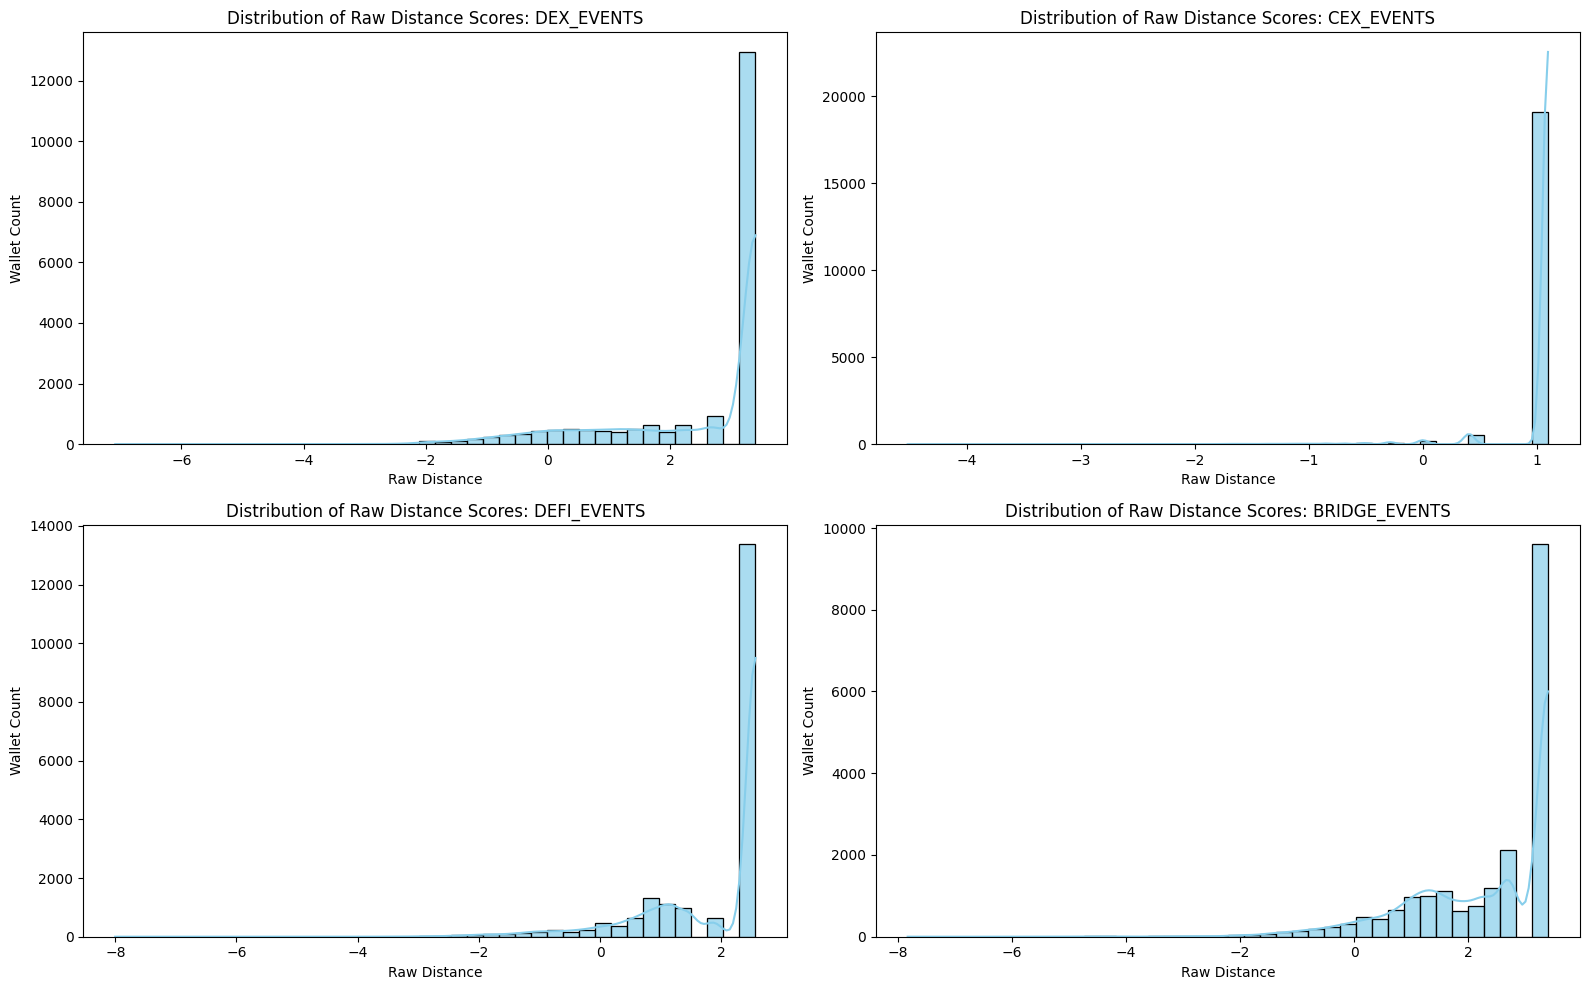

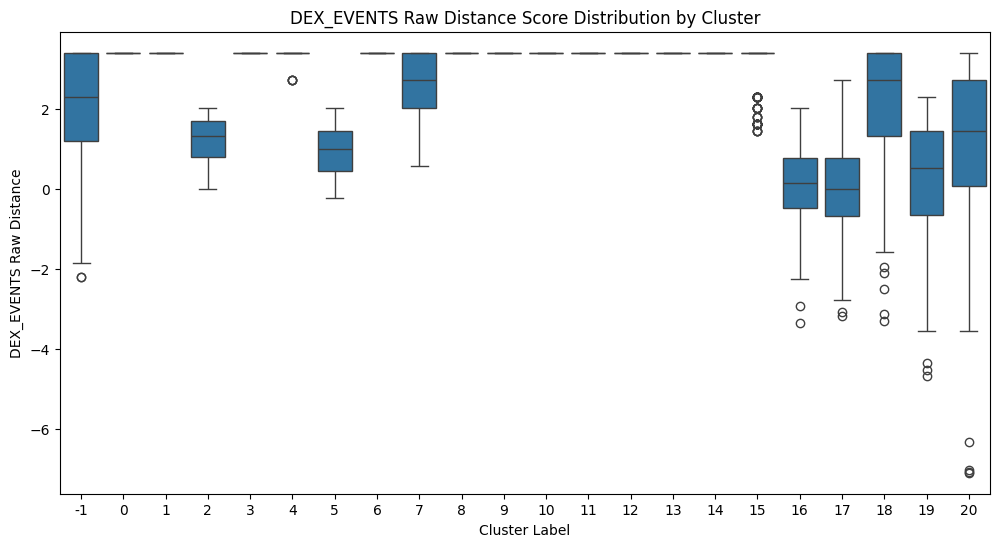

In [16]:
# Plot distribution of raw distance scores for each feature overall and by cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
for i, feature in enumerate(features):
    ax = axes[i]
    dist_col = f'{feature}_RAW_DIST'
    sns.histplot(raw_distance_df[dist_col], bins=40, kde=True, ax=ax, color='skyblue', alpha=0.7)
    ax.set_title(f'Distribution of Raw Distance Scores: {feature}')
    ax.set_xlabel('Raw Distance')
    ax.set_ylabel('Wallet Count')
plt.tight_layout()
plt.show()

# By cluster (example for DEX_EVENTS, repeat for others as needed)
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_label', y='DEX_EVENTS_RAW_DIST', data=raw_distance_df)
plt.title('DEX_EVENTS Raw Distance Score Distribution by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('DEX_EVENTS Raw Distance')
plt.show()

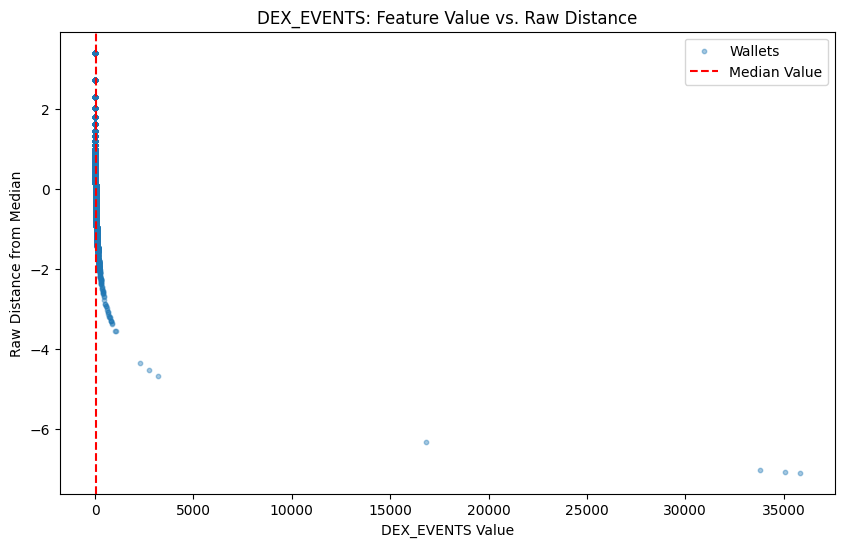

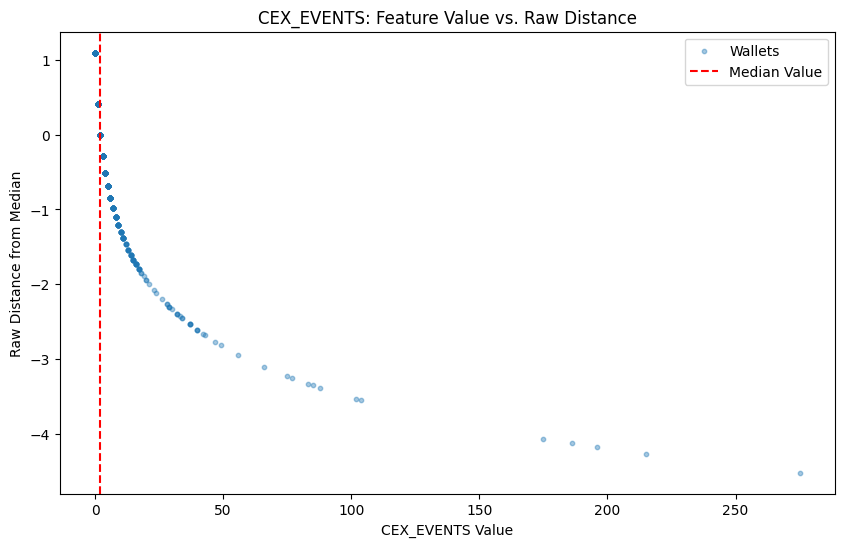

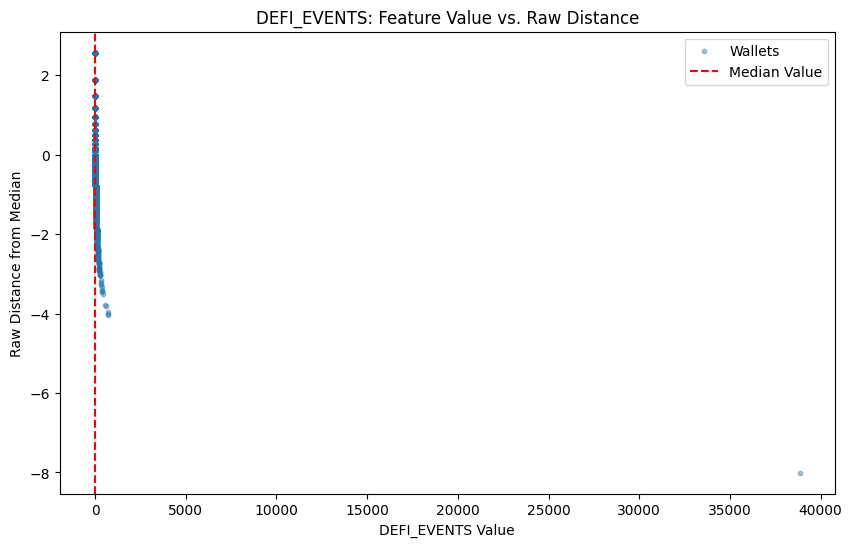

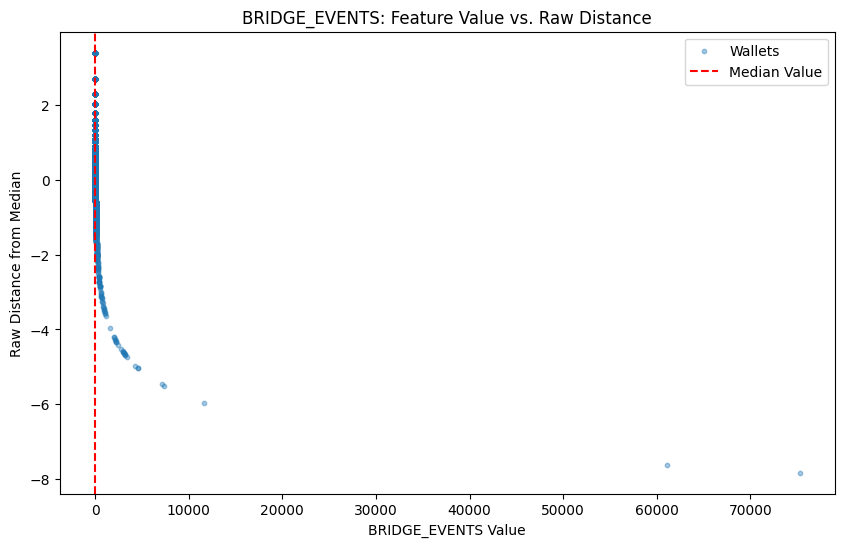

In [17]:
# Relate raw distance scores to feature values and medians, visualise relationship
for feature in features:
    plt.figure(figsize=(10, 6))
    plt.scatter(raw_distance_df[feature], raw_distance_df[f'{feature}_RAW_DIST'], alpha=0.4, s=10, label='Wallets')
    median_val = raw_distance_df[f'{feature}_MEDIAN'].iloc[0] if f'{feature}_MEDIAN' in raw_distance_df.columns else raw_distance_df[feature].median()
    plt.axvline(median_val, color='red', linestyle='--', label='Median Value')
    plt.title(f'{feature}: Feature Value vs. Raw Distance')
    plt.xlabel(f'{feature} Value')
    plt.ylabel('Raw Distance from Median')
    plt.legend()
    plt.show()

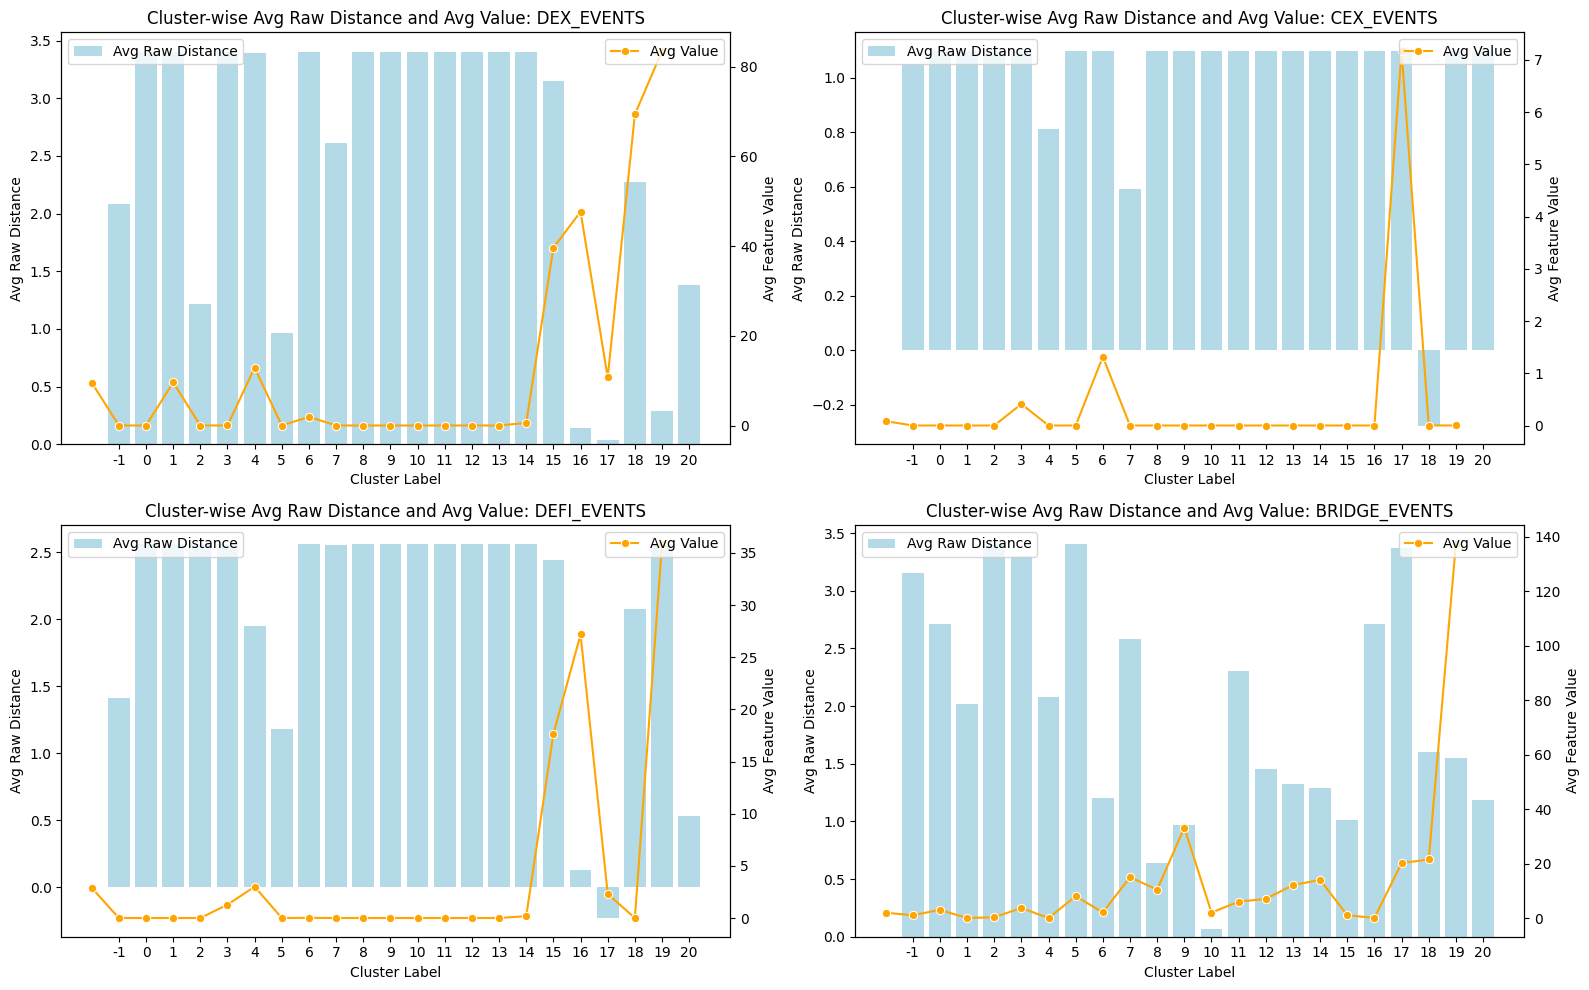

In [18]:
# Compute and visualise average raw distance scores per cluster and feature, compare to average feature values
avg_raw_distances = raw_distance_df.groupby('cluster_label')[[f'{f}_RAW_DIST' for f in features]].mean().reset_index()
avg_feature_values = raw_distance_df.groupby('cluster_label')[features].mean().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
for i, feature in enumerate(features):
    ax = axes[i]
    ax2 = ax.twinx()
    sns.barplot(x='cluster_label', y=f'{feature}_RAW_DIST', data=avg_raw_distances, ax=ax, color='skyblue', alpha=0.7, label='Avg Raw Distance')
    sns.lineplot(x='cluster_label', y=feature, data=avg_feature_values, ax=ax2, color='orange', marker='o', label='Avg Value')
    ax.set_title(f'Cluster-wise Avg Raw Distance and Avg Value: {feature}')
    ax.set_xlabel('Cluster Label')
    ax.set_ylabel('Avg Raw Distance')
    ax2.set_ylabel('Avg Feature Value')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [19]:
# Highlight wallets with highest and lowest raw distance scores for each feature, relate to cluster and feature value
for feature in features:
    dist_col = f'{feature}_RAW_DIST'
    print(f'\nTop 5 wallets with highest {feature} raw distance:')
    top = raw_distance_df.nlargest(5, dist_col)
    display(top[['WALLET', 'cluster_label', feature, dist_col]])
    print(f'\nTop 5 wallets with lowest {feature} raw distance:')
    bottom = raw_distance_df.nsmallest(5, dist_col)
    display(bottom[['WALLET', 'cluster_label', feature, dist_col]])


Top 5 wallets with highest DEX_EVENTS raw distance:


,WALLET,cluster_label,DEX_EVENTS,DEX_EVENTS_RAW_DIST
2,0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9,12,0,3.401197
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,3,0,3.401197
5,0x1198c8f481d4e63f24e3841a6961f1c71edbee14,3,0,3.401197
6,0xdf2dcebdb3c9d2de6a9132708ccbd638acd89d35,15,0,3.401197
7,0x7ab5985280217f28ad075e821e1abd94c4a3f6a6,6,0,3.401197



Top 5 wallets with lowest DEX_EVENTS raw distance:


,WALLET,cluster_label,DEX_EVENTS,DEX_EVENTS_RAW_DIST
5393,0x227ba91878cd157c3b5f43c5fbf452dc64f53ab5,20,35806,-7.084701
1825,0x8589ed02d6a4c2625d64c3fea62aeb58ed1db107,20,35049,-7.063334
18947,0xa81e4d5f454758d43d55c2afd0b61d45bbe16bdf,20,33816,-7.027522
4876,0xbc8a36cb3fa23afc95124e03fc5127da068394fa,20,16798,-6.327877
4771,0xb17f5972698087864fd05610c8a38f96f298d501,19,3183,-4.664696



Top 5 wallets with highest CEX_EVENTS raw distance:


,WALLET,cluster_label,CEX_EVENTS,CEX_EVENTS_RAW_DIST
0,0xecb113be97a619aa4d070491505847000f964448,7,0,1.098612
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,-1,0,1.098612
2,0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9,12,0,1.098612
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,3,0,1.098612
4,0xa967e15e71455940dfab4c08719abae50401babd,19,0,1.098612



Top 5 wallets with lowest CEX_EVENTS raw distance:


,WALLET,cluster_label,CEX_EVENTS,CEX_EVENTS_RAW_DIST
12164,0xd727183b291c887a9ab7f1ef77f99e0e780c7f60,18,275,-4.521789
6353,0x9a168f019f0adee2b052d5efd10bdb569e76c756,18,215,-4.276666
5604,0x91dca37856240e5e1906222ec79278b16420dc92,18,196,-4.184591
7617,0x426278fe13b017d60e5d1a9ca8db7ed63cdc1cca,18,186,-4.132496
8133,0xacf7ae354e732bc189a16a04c8aa3b244b08f49a,18,175,-4.071872



Top 5 wallets with highest DEFI_EVENTS raw distance:


,WALLET,cluster_label,DEFI_EVENTS,DEFI_EVENTS_RAW_DIST
0,0xecb113be97a619aa4d070491505847000f964448,7,0,2.564949
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,-1,0,2.564949
2,0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9,12,0,2.564949
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,3,0,2.564949
4,0xa967e15e71455940dfab4c08719abae50401babd,19,0,2.564949



Top 5 wallets with lowest DEFI_EVENTS raw distance:


,WALLET,cluster_label,DEFI_EVENTS,DEFI_EVENTS_RAW_DIST
10520,0x2aa6845f7e84b2cc1619c823bf4f6b04ec733f2c,20,38838,-8.002231
11889,0x1177e23637f4a35244fb9cf124663f3e1ecd7287,20,738,-4.040349
6278,0x322d7924bde43dc5e69c5401890cc074a26cbe27,20,709,-4.000316
13245,0xea90d635cbeaeb324e26c5f6e852cd7af049ed2c,17,689,-3.971742
6045,0x8621faf9926baae2892a0d715388d891ae79b877,20,583,-3.804952



Top 5 wallets with highest BRIDGE_EVENTS raw distance:


,WALLET,cluster_label,BRIDGE_EVENTS,BRIDGE_EVENTS_RAW_DIST
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,-1,0,3.401197
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,3,0,3.401197
5,0x1198c8f481d4e63f24e3841a6961f1c71edbee14,3,0,3.401197
8,0xb9942c8704b43a771a35849d5cdf0dd0384142ee,-1,0,3.401197
9,0xd45cd23f26ce3b9a5220c01a8bfc70f6682246a7,7,0,3.401197



Top 5 wallets with lowest BRIDGE_EVENTS raw distance:


,WALLET,cluster_label,BRIDGE_EVENTS,BRIDGE_EVENTS_RAW_DIST
6262,0x81af0ba454e37d0f2813c2b1ce0adc221d9d2c09,20,75240,-7.827254
2604,0xcc09c0bdb33e6bb53437860ae823b15558397576,20,61066,-7.618530
5822,0xbbe8f5fdcef4449c0a1a333b3fd0f2b3898ac8a2,20,11616,-5.959027
4882,0x1a211175a5d6dec6fe7f61ffca24afd7d1815436,20,7412,-5.509793
4642,0x614a4ff997a7681f7fc03f496bb40db34e84676b,20,7129,-5.470869


# Analysis of Weighted Distance Scores (`weighted_distances.csv`)
This section repeats all statistical evidence and visualisation functionality for the weighted distance scores, using `weighted_distances.csv`.

In [20]:
# Load weighted distance scores and merge with main clustering data
weighted_distance_df = pd.read_csv('../data/processed_data/interaction_mode_results/main_clustering/full_weighted_distances.csv')
# Columns: WALLET, cluster_label, <features...>, <feature>_MEDIAN, <feature>_WEIGHTED_DIST
features = ['DEX_EVENTS', 'CEX_EVENTS', 'DEFI_EVENTS', 'BRIDGE_EVENTS']
weighted_distance_cols = [f'{f}_WEIGHTED_DIST' for f in features]
weighted_distance_df.head()

,WALLET,TX_PER_MONTH,TOKEN_DIVERSITY,PROTOCOL_DIVERSITY,TOTAL_TRANSFER_USD,INTERACTION_DIVERSITY,ACTIVE_DURATION_DAYS,AVG_TRANSFER_USD,USD_TRANSFER_STDDEV,DEX_EVENTS,...,BRIDGE_TOTAL_VOLUME_USD,cluster_label,DEX_EVENTS_MEDIAN,CEX_EVENTS_MEDIAN,BRIDGE_EVENTS_MEDIAN,DEFI_EVENTS_MEDIAN,DEX_EVENTS_WEIGHTED_DIST,CEX_EVENTS_WEIGHTED_DIST,BRIDGE_EVENTS_WEIGHTED_DIST,DEFI_EVENTS_WEIGHTED_DIST
0,0xecb113be97a619aa4d070491505847000f964448,8.166667,6,9,2840.47,5,177,41.166232,88.745481,5,...,499.88,7,29.0,2.0,29.0,12.0,0.341202,0.0,0.278943,0.0
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,8.666667,2,8,3733.59,10,172,56.569545,185.180716,1,...,0.00,-1,29.0,2.0,29.0,12.0,0.796205,0.0,0.000000,0.0
2,0x2465ba1d82c7faf5cfc1b4f0e3c606800e1caac9,13.000000,5,26,3771.93,14,169,62.865500,135.890912,0,...,0.00,12,29.0,2.0,29.0,12.0,0.000000,0.0,0.537393,0.0
3,0xa5a1a2abcc2b67990b37b749c4e840f1fa093c97,6.833333,1,2,12977.28,2,170,370.779429,318.130714,0,...,0.00,3,29.0,2.0,29.0,12.0,0.000000,0.0,0.000000,0.0
4,0xa967e15e71455940dfab4c08719abae50401babd,7.500000,5,6,18935.76,6,156,236.697000,478.737614,5,...,1206.05,19,29.0,2.0,29.0,12.0,0.202369,0.0,0.212044,0.0


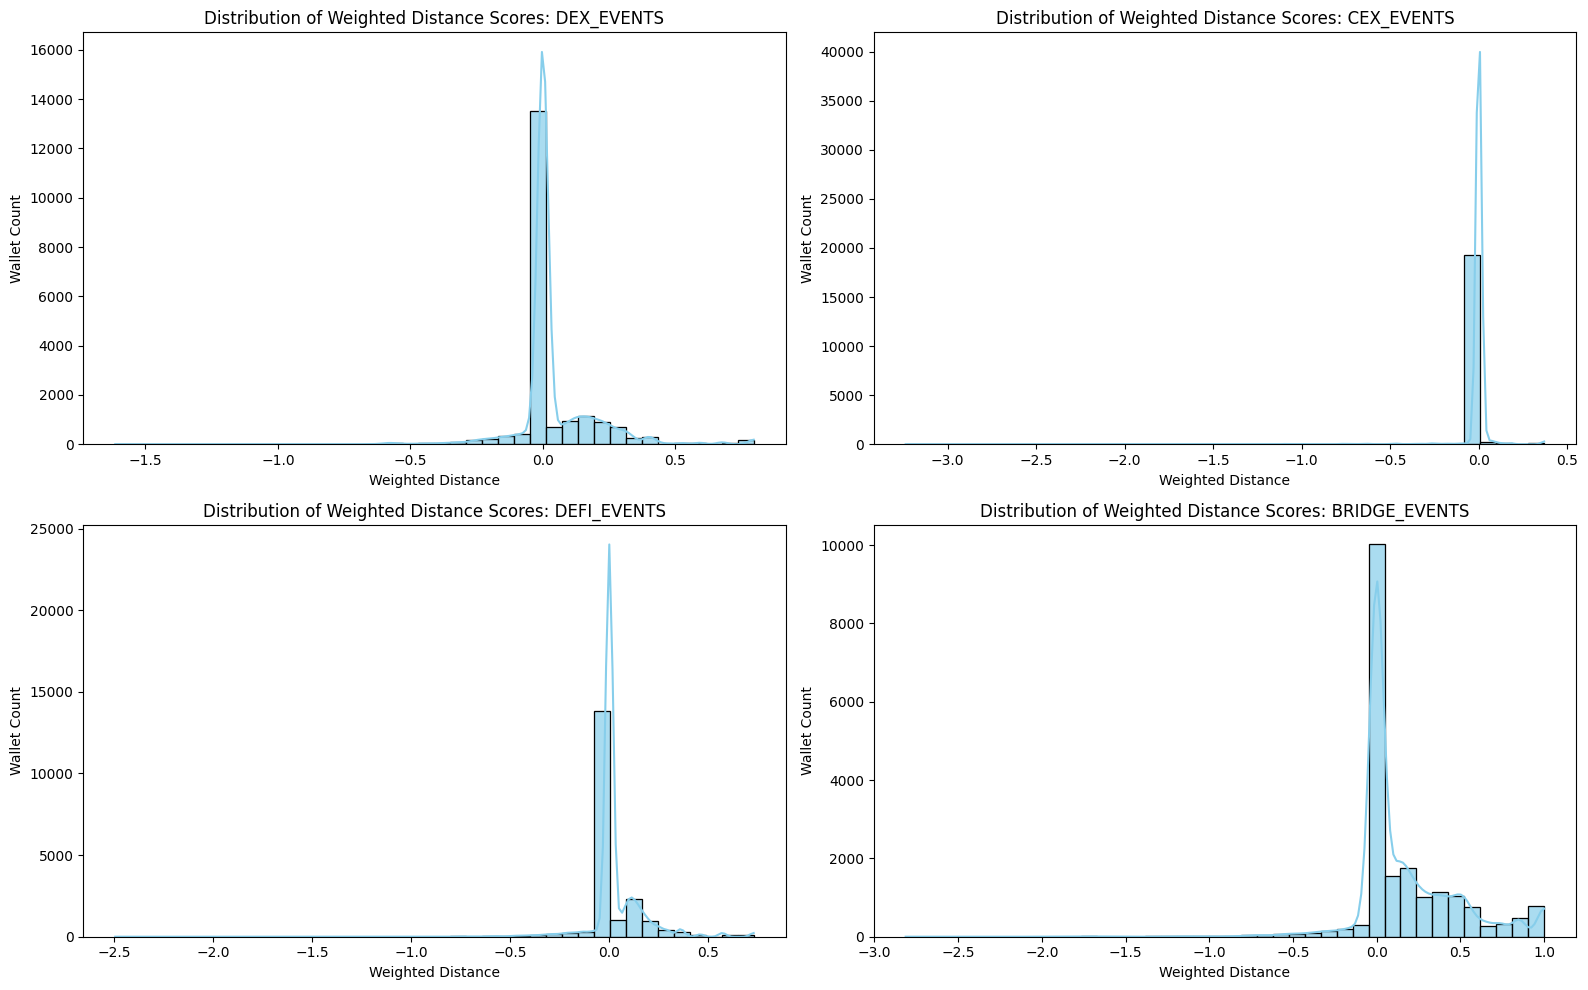

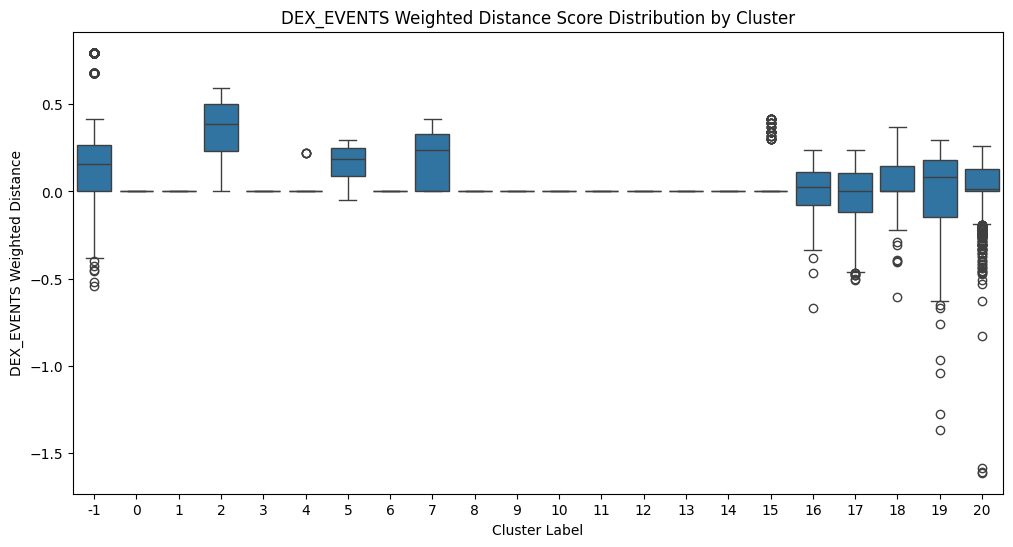

In [21]:
# Plot distribution of weighted distance scores for each feature overall and by cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
for i, feature in enumerate(features):
    ax = axes[i]
    dist_col = f'{feature}_WEIGHTED_DIST'
    sns.histplot(weighted_distance_df[dist_col], bins=40, kde=True, ax=ax, color='skyblue', alpha=0.7)
    ax.set_title(f'Distribution of Weighted Distance Scores: {feature}')
    ax.set_xlabel('Weighted Distance')
    ax.set_ylabel('Wallet Count')
plt.tight_layout()
plt.show()

# By cluster (example for DEX_EVENTS, repeat for others as needed)
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_label', y='DEX_EVENTS_WEIGHTED_DIST', data=weighted_distance_df)
plt.title('DEX_EVENTS Weighted Distance Score Distribution by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('DEX_EVENTS Weighted Distance')
plt.show()

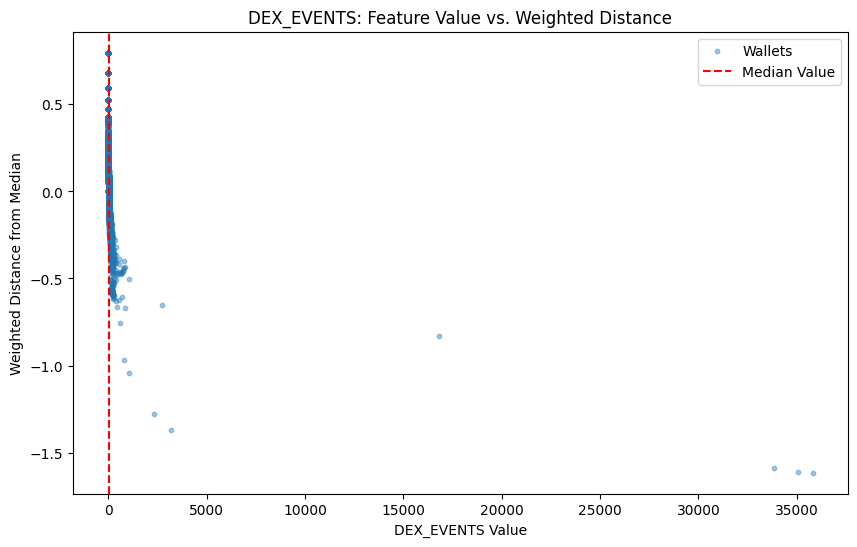

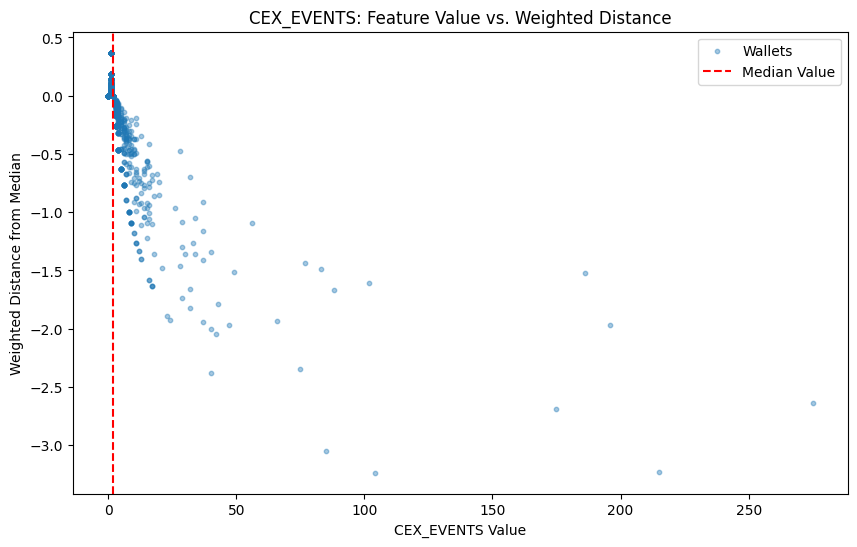

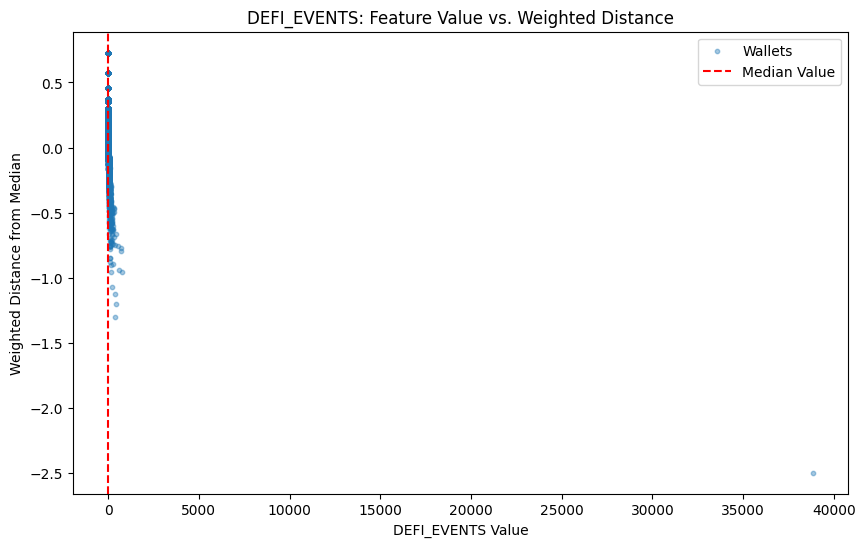

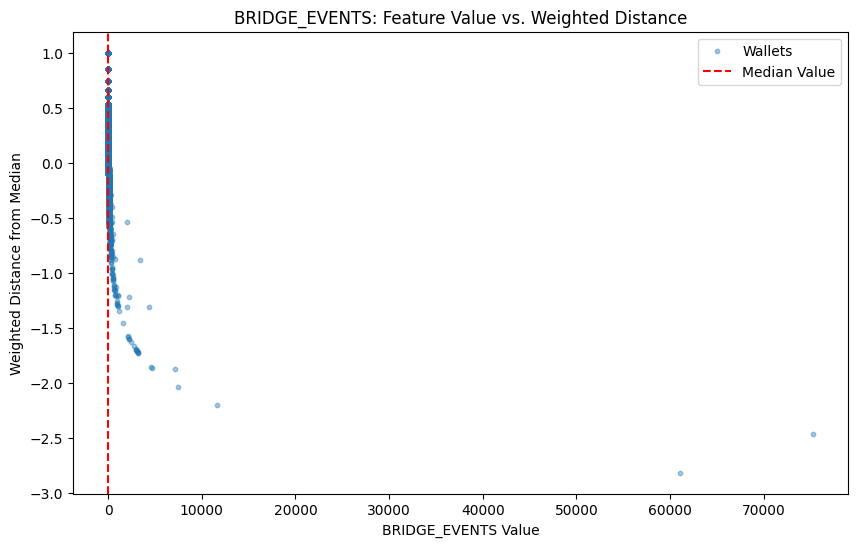

In [22]:
# Relate weighted distance scores to feature values and medians, visualise relationship
for feature in features:
    plt.figure(figsize=(10, 6))
    plt.scatter(weighted_distance_df[feature], weighted_distance_df[f'{feature}_WEIGHTED_DIST'], alpha=0.4, s=10, label='Wallets')
    median_val = weighted_distance_df[f'{feature}_MEDIAN'].iloc[0] if f'{feature}_MEDIAN' in weighted_distance_df.columns else weighted_distance_df[feature].median()
    plt.axvline(median_val, color='red', linestyle='--', label='Median Value')
    plt.title(f'{feature}: Feature Value vs. Weighted Distance')
    plt.xlabel(f'{feature} Value')
    plt.ylabel('Weighted Distance from Median')
    plt.legend()
    plt.show()

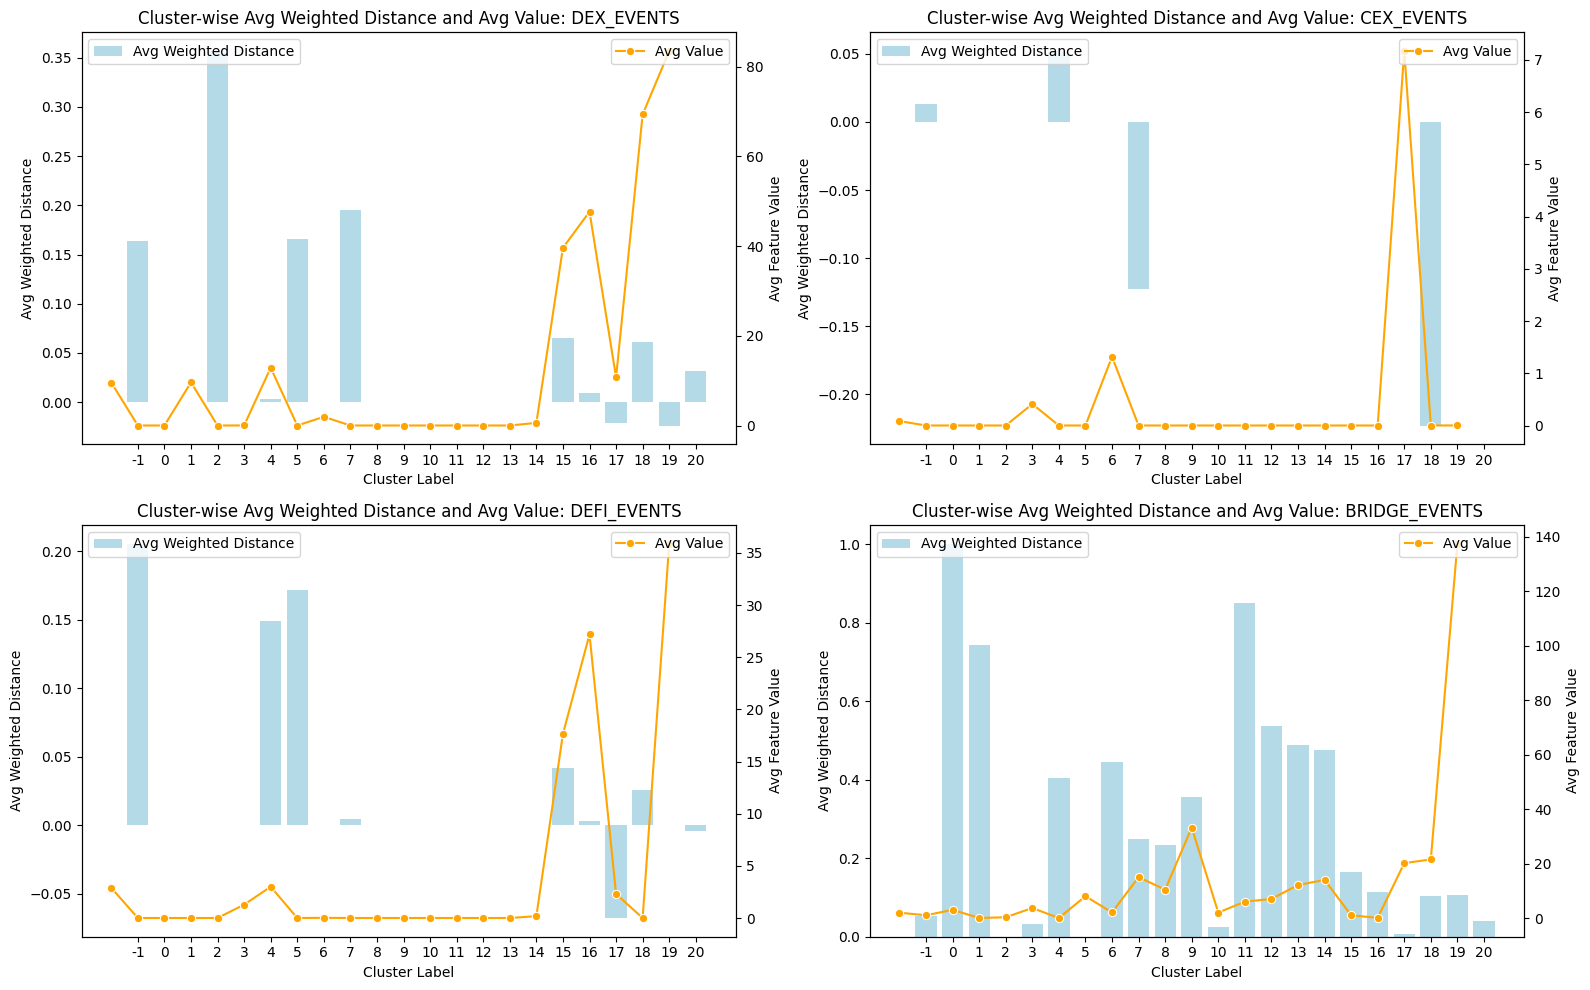

In [23]:
# Compute and visualise average weighted distance scores per cluster and feature, compare to average feature values
avg_weighted_distances = weighted_distance_df.groupby('cluster_label')[[f'{f}_WEIGHTED_DIST' for f in features]].mean().reset_index()
avg_feature_values = weighted_distance_df.groupby('cluster_label')[features].mean().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
for i, feature in enumerate(features):
    ax = axes[i]
    ax2 = ax.twinx()
    sns.barplot(x='cluster_label', y=f'{feature}_WEIGHTED_DIST', data=avg_weighted_distances, ax=ax, color='skyblue', alpha=0.7, label='Avg Weighted Distance')
    sns.lineplot(x='cluster_label', y=feature, data=avg_feature_values, ax=ax2, color='orange', marker='o', label='Avg Value')
    ax.set_title(f'Cluster-wise Avg Weighted Distance and Avg Value: {feature}')
    ax.set_xlabel('Cluster Label')
    ax.set_ylabel('Avg Weighted Distance')
    ax2.set_ylabel('Avg Feature Value')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [24]:
# Highlight wallets with highest and lowest weighted distance scores for each feature, relate to cluster and feature value
for feature in features:
    dist_col = f'{feature}_WEIGHTED_DIST'
    print(f'\nTop 5 wallets with highest {feature} weighted distance:')
    top = weighted_distance_df.nlargest(5, dist_col)
    display(top[['WALLET', 'cluster_label', feature, dist_col]])
    print(f'\nTop 5 wallets with lowest {feature} weighted distance:')
    bottom = weighted_distance_df.nsmallest(5, dist_col)
    display(bottom[['WALLET', 'cluster_label', feature, dist_col]])


Top 5 wallets with highest DEX_EVENTS weighted distance:


,WALLET,cluster_label,DEX_EVENTS,DEX_EVENTS_WEIGHTED_DIST
1,0x76c1cf35f54c67bc4fec5ba1411f5c0825a4a50d,-1,1,0.796205
149,0x1aa01deeabeb0b52f44554c4958302dc711d38c2,-1,1,0.796205
178,0x3f152c1a3953471fa18c144022d71f30fc189a50,-1,1,0.796205
253,0xdebbb56346faa22128abebfce7adcc6fffe7f427,-1,1,0.796205
400,0x06acd3628e49bffec7d306dc1b9a73bb5cbb6693,-1,1,0.796205



Top 5 wallets with lowest DEX_EVENTS weighted distance:


,WALLET,cluster_label,DEX_EVENTS,DEX_EVENTS_WEIGHTED_DIST
5393,0x227ba91878cd157c3b5f43c5fbf452dc64f53ab5,20,35806,-1.614299
1825,0x8589ed02d6a4c2625d64c3fea62aeb58ed1db107,20,35049,-1.608691
18947,0xa81e4d5f454758d43d55c2afd0b61d45bbe16bdf,20,33816,-1.588571
4771,0xb17f5972698087864fd05610c8a38f96f298d501,19,3183,-1.371486
12052,0xd9f19014684d31e1ea91ed20fd6809454cca98b9,19,2311,-1.277395



Top 5 wallets with highest CEX_EVENTS weighted distance:


,WALLET,cluster_label,CEX_EVENTS,CEX_EVENTS_WEIGHTED_DIST
360,0x7ead26550efc035401e61251686e13df58b613b7,-1,1,0.36907
1306,0x96c28a5d631845f3311662292ee91a6c3776f4ea,-1,1,0.36907
1477,0xcc37c898732560f7ac7cf25ce92c1c6dc7088971,-1,1,0.36907
1828,0x8c2e1f776e98316223536dd576f6f2bf80f9912d,-1,1,0.36907
1849,0x5763cb071b324e58f31488be87dc59fe89c66fea,-1,1,0.36907



Top 5 wallets with lowest CEX_EVENTS weighted distance:


,WALLET,cluster_label,CEX_EVENTS,CEX_EVENTS_WEIGHTED_DIST
16666,0x645cb372b84e56609a0c7347daa548e8981e74b9,18,104,-3.236217
6353,0x9a168f019f0adee2b052d5efd10bdb569e76c756,18,215,-3.232187
11037,0x06cdfc78c9bfe7c0a28661a98a1b16958be1108e,18,85,-3.054522
8133,0xacf7ae354e732bc189a16a04c8aa3b244b08f49a,18,175,-2.692904
12164,0xd727183b291c887a9ab7f1ef77f99e0e780c7f60,18,275,-2.641998



Top 5 wallets with highest DEFI_EVENTS weighted distance:


,WALLET,cluster_label,DEFI_EVENTS,DEFI_EVENTS_WEIGHTED_DIST
418,0xe347849e44703152b00b644100610b1e104702e9,-1,1,0.729762
444,0x2ee55128fb0a531618abbef9813c679de458a366,-1,1,0.729762
684,0x2f8607395901bcb20969cb72e694351b063b93ea,-1,1,0.729762
2233,0x09eecef391f5c2ce2d72ceda9a8eb7a36e68c009,-1,1,0.729762
3236,0xa7a7865616212cbd7ac91dcb8377bad3573cc453,-1,1,0.729762



Top 5 wallets with lowest DEFI_EVENTS weighted distance:


,WALLET,cluster_label,DEFI_EVENTS,DEFI_EVENTS_WEIGHTED_DIST
10520,0x2aa6845f7e84b2cc1619c823bf4f6b04ec733f2c,20,38838,-2.496389
16392,0xc07b93be0f51466af8f25bca56be6cd0d52f7b2d,20,366,-1.302331
1430,0x41ee5873efffb8f1e25b5db45b7812769ac5698f,20,407,-1.204708
18705,0xc8a02cb5bb2bcb010ac3cb936a162240c44fa1c1,20,397,-1.127103
7354,0x3cbded22f878afc8d39dcd744d3fe62086b76193,20,201,-1.069541



Top 5 wallets with highest BRIDGE_EVENTS weighted distance:


,WALLET,cluster_label,BRIDGE_EVENTS,BRIDGE_EVENTS_WEIGHTED_DIST
47,0x0959717fc496e7bf7b21a135d0b8960280e42edb,0,1,1.0
48,0x432393d79b15b14c60c766e4fa0ad9f2215d929d,0,1,1.0
69,0x104dfddd425c63689aa45f3c5244a2654400f0df,0,1,1.0
112,0x2878ca130ca984afb3595b466d25bd110a31156b,0,1,1.0
164,0xc379068bbe548fd31b0a22322421ef2f236221b8,0,1,1.0



Top 5 wallets with lowest BRIDGE_EVENTS weighted distance:


,WALLET,cluster_label,BRIDGE_EVENTS,BRIDGE_EVENTS_WEIGHTED_DIST
2604,0xcc09c0bdb33e6bb53437860ae823b15558397576,20,61066,-2.813290
6262,0x81af0ba454e37d0f2813c2b1ce0adc221d9d2c09,20,75240,-2.463446
5822,0xbbe8f5fdcef4449c0a1a333b3fd0f2b3898ac8a2,20,11616,-2.200486
4882,0x1a211175a5d6dec6fe7f61ffca24afd7d1815436,20,7412,-2.034598
4642,0x614a4ff997a7681f7fc03f496bb40db34e84676b,20,7129,-1.873828
